In [2]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from scipy.stats import mode


# 数据预处理
def load_images(image_paths, target_size=(256, 256)):
    images = []
    labels = []

    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB').resize(target_size)
        image = np.array(image) / 255.0
        label = image_path.split('/')[-2]
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)


# 内建的ANN模型
class ANNModel:
    def __init__(self, input_shape, num_classes):
        self.model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train):
        return self.model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    def predict(self, X):
        return self.model.predict(X)


# 无监督模型 (GMM)
class UnsupervisedGMM:
    def __init__(self, n_components):
        self.model = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)


# Ensemble模型
class EnsembleModel:
    def __init__(self, supervised_model, unsupervised_model):
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y):
        history = self.supervised_model.train(X, y)
        features = self.supervised_model.predict(X)
        print(features.shape)
        self.unsupervised_model.fit(features)
        return history

    def predict(self, X):
        features = self.supervised_model.predict(X)
        return self.unsupervised_model.predict(features)


# 可视化训练历史
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()


# 重新映射聚类标签以匹配真实标签
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)
    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        # Find the cluster label that most frequently occurs with this true label
        most_common = mode(predicted_labels[mask])[0][0]
        mapped_labels[predicted_labels == most_common] = true_label
    return mapped_labels


# 加载数据和训练模型
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

2023-12-03 17:05:30.320858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-03 17:05:30.320888: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-03 17:05:30.320897: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-03 17:05:30.320928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 17:05:30.320945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-12-03 17:05:31.494542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 61ms/step - loss: 143.8605 - accuracy: 0.1983 - val_loss: 132.1898 - val_accuracy: 0.2989
Epoch 2/10
 3/11 [=======>......................] - ETA: 0s - loss: 94.8290 - accuracy: 0.3958

2023-12-03 17:05:32.202391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 32ms/step - loss: 77.6337 - accuracy: 0.4626 - val_loss: 29.6599 - val_accuracy: 0.7011
Epoch 3/10
11/11 [==============================] - 0s 29ms/step - loss: 14.4132 - accuracy: 0.7874 - val_loss: 7.6213 - val_accuracy: 0.8851
Epoch 4/10
11/11 [==============================] - 0s 29ms/step - loss: 5.3457 - accuracy: 0.8534 - val_loss: 2.3356 - val_accuracy: 0.8736
Epoch 5/10
11/11 [==============================] - 0s 32ms/step - loss: 1.1704 - accuracy: 0.9397 - val_loss: 1.3208 - val_accuracy: 0.9770
Epoch 6/10
11/11 [==============================] - 0s 29ms/step - loss: 0.2619 - accuracy: 0.9828 - val_loss: 0.5301 - val_accuracy: 0.9655
Epoch 7/10
11/11 [==============================] - 0s 30ms/step - loss: 0.5053 - accuracy: 0.9684 - val_loss: 0.0565 - val_accuracy: 0.9885
Epoch 8/10
11/11 [==============================] - 0s 31ms/step - loss: 1.3940 - accuracy: 0.9598 - val_loss: 1.3656 - val_accuracy: 0.9310
Epoch 9/10
11/11 [===

2023-12-03 17:05:35.810591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)


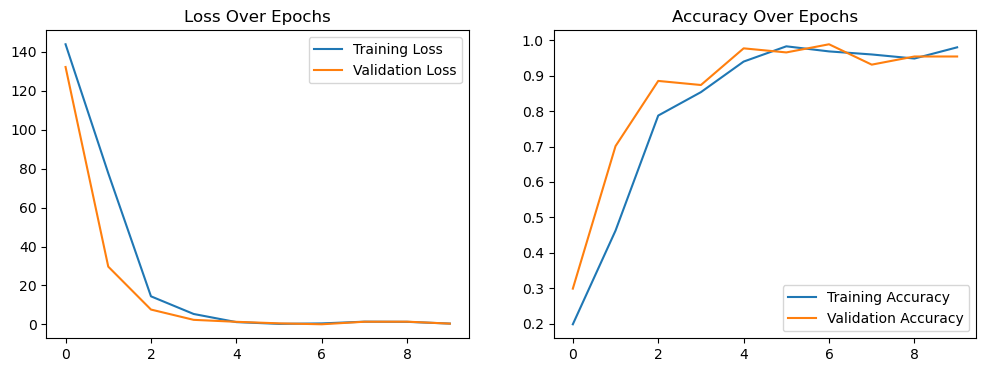

In [3]:
# 构建模型
ann_model = ANNModel(X_train[0].shape, len(np.unique(y_train)))
gmm_model = UnsupervisedGMM(n_components=len(np.unique(y_train)))
ensemble_model = EnsembleModel(ann_model, gmm_model)

# 训练模型
history = ensemble_model.fit(X_train, y_train)

# 可视化损失和准确率
plot_history(history)

In [4]:
# 进行预测
features_test = ann_model.predict(X_test)  # 先通过ANN获得特征
predicted_clusters = gmm_model.predict(features_test)  # 用GMM进行聚类预测

4/4 [==============================] - 0s 22ms/step


In [5]:
predicted_clusters, y_test

(array([24, 30, 23, 27, 27, 31,  3, 31, 31,  1, 28,  8, 11, 31, 27,  8, 20,
         2, 26, 29, 31, 13, 20,  1, 22, 28,  5, 26, 28, 26, 31, 14, 31,  4,
        29,  9, 20, 29, 13,  0, 12, 18,  6,  7,  0, 17, 12, 21, 23, 12, 25,
        15, 31, 31, 26, 24, 28,  0, 17, 27, 22, 14, 21, 22, 29, 27,  4, 10,
         1, 16,  9, 31, 10, 21, 15, 31, 29,  2, 10,  4, 18, 26, 25, 21,  6,
        28, 28, 30, 25, 23,  1,  4,  5, 20, 30, 13, 23,  1, 25, 22,  6, 28,
        17, 19,  0, 18, 19,  4,  7]),
 array([13, 22,  7, 23, 23, 12, 20, 12, 12,  0,  8,  2,  4, 12, 23,  2, 15,
        25,  3, 19, 12, 21, 15,  0, 30,  8,  1,  3,  8,  3, 12,  6, 12, 17,
        19, 11, 15, 19, 21, 16,  9, 27,  5, 26, 16, 14,  9, 10,  7,  9, 31,
        29, 12, 12,  3, 13,  8, 16, 14, 23, 30,  6, 10, 30, 19, 23, 17, 28,
         0, 18, 11, 12, 28, 10, 29, 12, 19, 25, 28, 17, 27,  3, 31, 10,  5,
         8,  8, 22, 31,  7,  0, 17,  1, 15, 22, 21,  7,  0, 31, 30,  5,  8,
        14, 24, 16, 27, 24, 17, 26]))

In [6]:
mapped_predictions = remap_labels(y_test, predicted_clusters)  # 重新映射聚类标签

/var/folders/fm/_6wfn0r96gjcpy7779d0j2fc0000gn/T/ipykernel_43954/3250691199.py:102: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common = mode(predicted_labels[mask])[0][0]


In [7]:
y_test, mapped_predictions

(array([13, 22,  7, 23, 23, 12, 20, 12, 12,  0,  8,  2,  4, 12, 23,  2, 15,
        25,  3, 19, 12, 21, 15,  0, 30,  8,  1,  3,  8,  3, 12,  6, 12, 17,
        19, 11, 15, 19, 21, 16,  9, 27,  5, 26, 16, 14,  9, 10,  7,  9, 31,
        29, 12, 12,  3, 13,  8, 16, 14, 23, 30,  6, 10, 30, 19, 23, 17, 28,
         0, 18, 11, 12, 28, 10, 29, 12, 19, 25, 28, 17, 27,  3, 31, 10,  5,
         8,  8, 22, 31,  7,  0, 17,  1, 15, 22, 21,  7,  0, 31, 30,  5,  8,
        14, 24, 16, 27, 24, 17, 26]),
 array([13, 22,  7, 23, 23, 12, 20, 12, 12,  0,  8,  2,  4, 12, 23,  2, 15,
        25,  3, 19, 12, 21, 15,  0, 30,  8,  1,  3,  8,  3, 12,  6, 12, 17,
        19, 11, 15, 19, 21, 16,  9, 27,  5, 26, 16, 14,  9, 10,  7,  9, 31,
        29, 12, 12,  3, 13,  8, 16, 14, 23, 30,  6, 10, 30, 19, 23, 17, 28,
         0, 18, 11, 12, 28, 10, 29, 12, 19, 25, 28, 17, 27,  3, 31, 10,  5,
         8,  8, 22, 31,  7,  0, 17,  1, 15, 22, 21,  7,  0, 31, 30,  5,  8,
        14, 24, 16, 27, 24, 17, 26]))

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


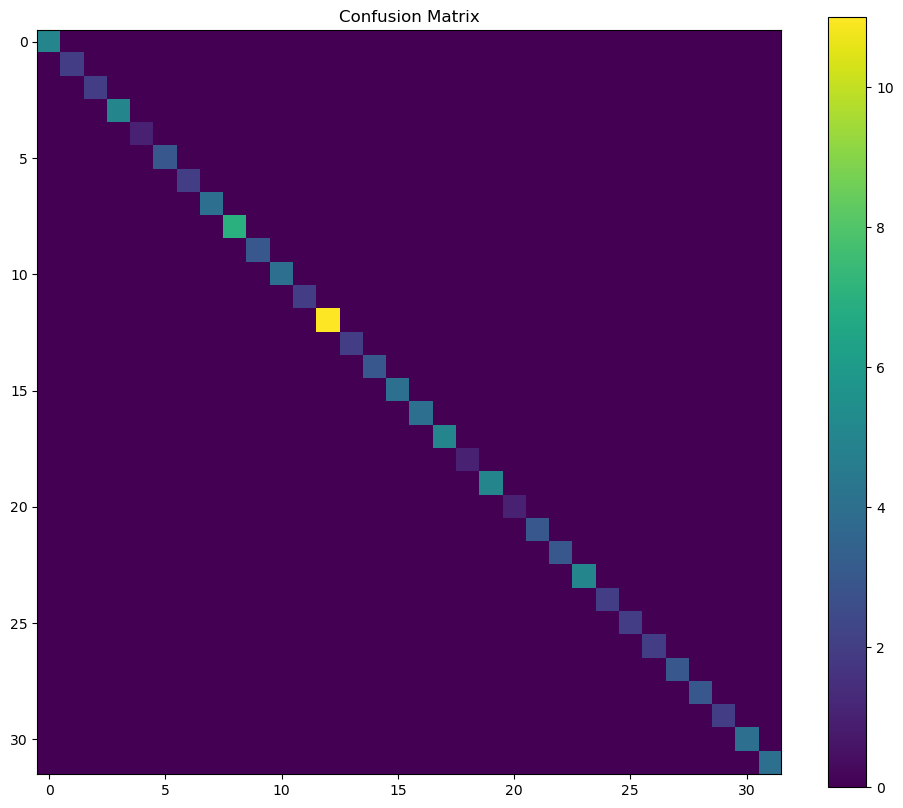

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         4
    

In [8]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, mapped_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 输出分类报告
print('Classification Report:')
print(classification_report(y_test, mapped_predictions))

# 计算准确率
accuracy = np.sum(mapped_predictions == y_test) / len(y_test)
print(f'Clustering Accuracy: {accuracy}')

4/4 [==============================] - 0s 19ms/step


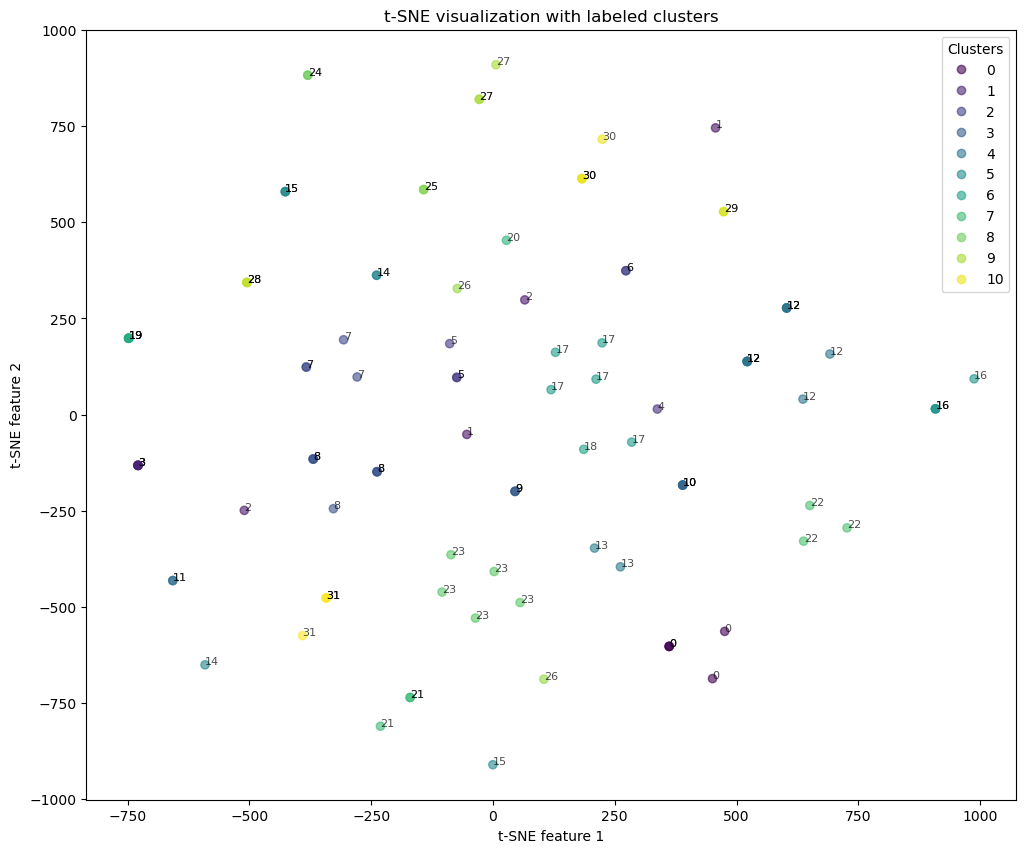

In [10]:
def visualize_clusters_with_labels(X, y, model, perplexity=30, learning_rate=200):
    # 通过神经网络模型提取特征
    features = model.predict(X)

    # 使用t-SNE降维到二维
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    X_reduced = tsne.fit_transform(features)

    # 绘制所有聚类的散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    # 为每个聚类的质心添加注释
    # 如果聚类数量很多，这可能会导致图表拥挤
    # unique_labels = np.unique(y)
    # for i, label in enumerate(unique_labels):
    #     xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
    #     txt = f'Cluster {label}'
    #     plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    # 如果你想为每个点标注标签，取消注释以下代码
    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Clusters")
    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann_model)

In [ ]:
# from sklearn.metrics import adjusted_rand_score
# 
# adjusted_rand_index = adjusted_rand_score(y_test, predictions)
# print("调整后的兰德指数：", adjusted_rand_index)

In [ ]:
# from sklearn.metrics import normalized_mutual_info_score
# 
# normalized_mutual_info = normalized_mutual_info_score(y_test, predictions)
# print("标准化互信息：", normalized_mutual_info)